In [8]:
import os
import math
import numpy as np
import h5py
import glob
from tqdm import tqdm
import scipy

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.ion()

# Read in deep drive data
dfiles = glob.glob('data/*.h5')
dfiles = glob.glob('/Users/davidleifer/Desktop/DanDoesData/self-driving/train_0000.h5')


In [9]:
dfiles

['/Users/davidleifer/Desktop/DanDoesData/self-driving/train_0000.h5']

In [14]:
# 999 data points, images are 3x227x227
# vehicle_states are just target at previous time
# no distance finder, but this is enough to work with
dfile = dfiles[8]

IndexError: list index out of range

In [16]:
dfile = dfiles[0]
 

In [19]:
h5f = h5py.File(dfile,'r')
A = dict(h5f.items())
%matplotlib inline


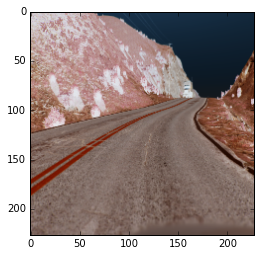

In [20]:
plt.imshow(A['images'].value[0].swapaxes(0,2).swapaxes(0,1))
AA = A['images'].value

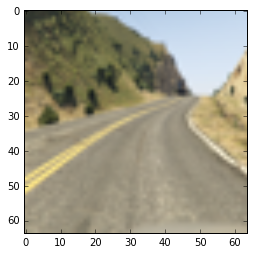

In [21]:
# look at targets
A['targets'].value[:2]
A['vehicle_states'].value[:2]

at = A['targets'].value[:-1]
av = A['vehicle_states'].value[1:]

# slim inputs
B = np.array(A['images'].value,dtype=np.uint8)
plt.imshow(B[0][::-1,:,:].transpose((1,2,0)))

B = B[:,::-1,:,:]

bb = scipy.misc.imresize(B[0],(128,128),'cubic','RGB')
plt.imshow(bb)

bb = scipy.misc.imresize(B[0],(64,64),'cubic','RGB')
plt.imshow(bb)

In [22]:
speedmax = None
speedmin = None
accelmax = None
accelmin = None

In [23]:
ndata = 0
imgsize = 64
# frame size
nrows = 64
ncols = 64

# speed, accel, distance, angle
real_in = Input(shape=(2,), name='real_input')

# video frame in, grayscale
frame_in = Input(shape=(3,nrows,ncols))

# convolution for image input
conv1 = Convolution2D(8,5,5,border_mode='same')
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D(pool_size=(2,2))(Econv_l1)

conv2 = Convolution2D(8,5,5,border_mode='same')
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D(pool_size=(2,2))(Econv_l2)

flat = Flatten()(pool_l2)

M = merge([flat,real_in], mode='concat', concat_axis=1)



In [24]:
D1 = Dense(64)(M)
ED1 = ELU()(D1)
D2 = Dense(32)(ED1)
ED2 = ELU()(D2)
D3 = Dense(32)(ED2)
ED3 = ELU()(D3)

A1 = Dense(32)(ED3)
EA1 = ELU()(A1)
S1 = Dense(32)(ED3)
ES1 = ELU()(S1)

Accel = Dense(1, activation='sigmoid')(EA1)
Steer = Dense(1, activation='sigmoid')(ES1)

model = Model(input=[real_in, frame_in], output=[Accel,Steer])

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])


In [34]:
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        #speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        #speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = A['targets'].value[:,4:]

In [35]:
h = model.fit([speedx, imgs], [targets[:,1], targets[:,0]],
                batch_size = 32, nb_epoch=10, verbose=1)

Epoch 1/10
999/999 [==============================] - 4s - loss: 0.1228 - dense_6_loss: 0.0807 - dense_7_loss: 0.0421 - dense_6_acc: 0.1662 - dense_7_acc: 0.1892     
Epoch 2/10
999/999 [==============================] - 5s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 3/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 4/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 5/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 6/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932    

In [36]:
h

In [37]:
h.history

{'dense_6_acc': [0.16616616616616617,
  0.1751751752199234,
  0.1751751752199234,
  0.17517517526467163,
  0.17517517526467163,
  0.17517517517517517,
  0.17517517517517517,
  0.17517517526467163,
  0.17517517517517517,
  0.17517517526467163],
 'dense_6_loss': [0.080679021524013697,
  0.059289186462029082,
  0.059289186372532623,
  0.059289187023246488,
  0.059289186365074582,
  0.059289186469487123,
  0.059289186607460839,
  0.059289186842389055,
  0.059289186279307141,
  0.059289186812556897],
 'dense_7_acc': [0.18918918923393743,
  0.19319319328268966,
  0.19319319323794143,
  0.19319319328268966,
  0.19319319328268966,
  0.19319319323794143,
  0.19319319322302536,
  0.1931931931931932,
  0.19319319328268966,
  0.19319319322302536],
 'dense_7_loss': [0.042085390189663507,
  0.024611184994146617,
  0.024611185054043989,
  0.024611185094597074,
  0.024611185181296773,
  0.024611185102987366,
  0.024611185422867304,
  0.024611184636393824,
  0.024611185136082413,
  0.024611185018618306

In [38]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 64, 64)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 64, 64)     608         input_1[0][0]                    
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 8, 64, 64)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 32, 32)     0           elu_1[0][0]                      
___________________________________________________________________________________________

In [39]:
print('freken epoch')

freken epoch


In [43]:
model.predict?